# CAS KAGGLE: Analisis de la seguretat de contrasenyes

### David Candela

# Introducció

Que faig i perquè.

# 1. Netejar i visualitzar el dataset

https://www.kaggle.com/bhavikbb/password-strength-classifier-dataset

In [1]:
Minuscules = [chr(c) for c in range(ord('a'), ord('z') + 1)]
Majuscules = [chr(c) for c in range(ord('A'), ord('Z') + 1)]
Xifres = [str(i) for i in range(10)]
Especials = ['.', ';', '-', '_', '+', '*', '<', '>', '[', ']', '{', '}', \
             '(', ')', '@', '#', '$', '%', '&', '/', '\\', '?', '!', '=', \
             '^', '~', ' ']
CaractersValids = Minuscules + Majuscules + Xifres + Especials
TipusCaracters = dict()
TipusCaracters.update({c: "Minuscules" for c in Minuscules})
TipusCaracters.update({c: "Majuscules" for c in Majuscules})
TipusCaracters.update({c: "Xifres" for c in Xifres})
TipusCaracters.update({c: "Especials" for c in Especials})

def isValid(contrasenya):
    try:
        # Treure les contrasenyes amb caracters que no consideri valids
        #   ja que no importa el format de descodificació especificat,
        #   Python es incapaç de llegir correctament tots els diferents caràcters
        #   caracters i sempre en surten de l'estil '\x03', '\x0f', '\x8d'
        #   o també §, ¶, ­, þ, ¤, ...
        return all(c in CaractersValids for c in contrasenya)
    except:
        # Truere les contrasenyes que Pandas converteixi continuament a float
        #   tot i que s'ha marcat la columna de passwords com strings
        return False

In [2]:
import os.path
import pandas as pd
import numpy as np

path = '../data/'
data_name = 'data.csv'
clean_name = 'clean_data.csv'
data_file = path + data_name
clean_file = path + clean_name
regenerate_file = False

if regenerate_file or not os.path.isfile(clean_file):
    assert os.path.isfile(data_file)
    # Saltarse les files on les dades no estiguin ben formategades
    dataset = pd.read_csv(data_file, on_bad_lines='skip', encoding='utf-8', dtype={'password': str, 'strength': np.int64})
    # Treure les dades que contenen caracters que no acceptem
    dataset = dataset[dataset.apply(lambda s: isValid(s['password']), axis=1)]
    # Guardar el nou dataset a un fitxer apart
    dataset.to_csv(clean_file, index=False)
    
dataset = pd.read_csv(clean_file)
dades = dataset.values
contrasenyes = dades[:,0]
dades_proteccio = dades[:,1].astype(np.int64)
noms = dataset.columns.values

In [3]:
dataset.head()

,password,strength
0,kzde5577,1
1,kino3434,1
2,visi7k1yr,1
3,megzy123,1
4,lamborghin1,1


In [4]:
dataset.describe()

,strength
count,669234.000000
mean,0.990301
std,0.507769
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2.000000


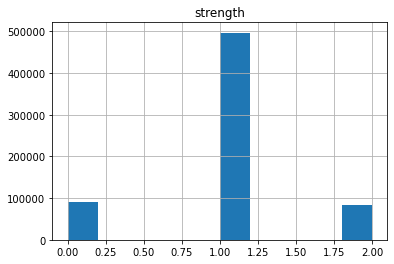

In [5]:
import matplotlib.pyplot as plt

dataset.hist()
plt.show()

# 2. Extreure dades

## Predictabilitat

Primer mirarem que tan probables i que tan facils de predir les contrasenyes.  
En concret mirarem:
* Probabilitat dels caracters que utilitza
* Probabilitat d'una sequencia com aquesta
* Com de barrejats estàn els carcters
* Que tan llarga és la contrasenya

In [6]:
def recompte(contrasenya, individual, predictabilitat):
    c_ = ''
    for c in contrasenya:
        predictabilitat[c_][c] += 1
        predictabilitat[c_]['total'] += 1
        individual[c] += 1
        individual['total'] += 1
        c_ = c

individual = {c:0 for c in CaractersValids + ['total']}
predictabilitat = {c:{c:1 if not c == 'total' else len(CaractersValids) for c in CaractersValids + ['total']} for c in CaractersValids + ['']}

for p in dades[:,0]:
    recompte(p, individual, predictabilitat)

individual_total = individual['total']
predictabilitat_total = {c:predictabilitat[c]['total'] for c in predictabilitat.keys()}

individual.pop('total')
for k in predictabilitat.keys():
    predictabilitat[k].pop('total')

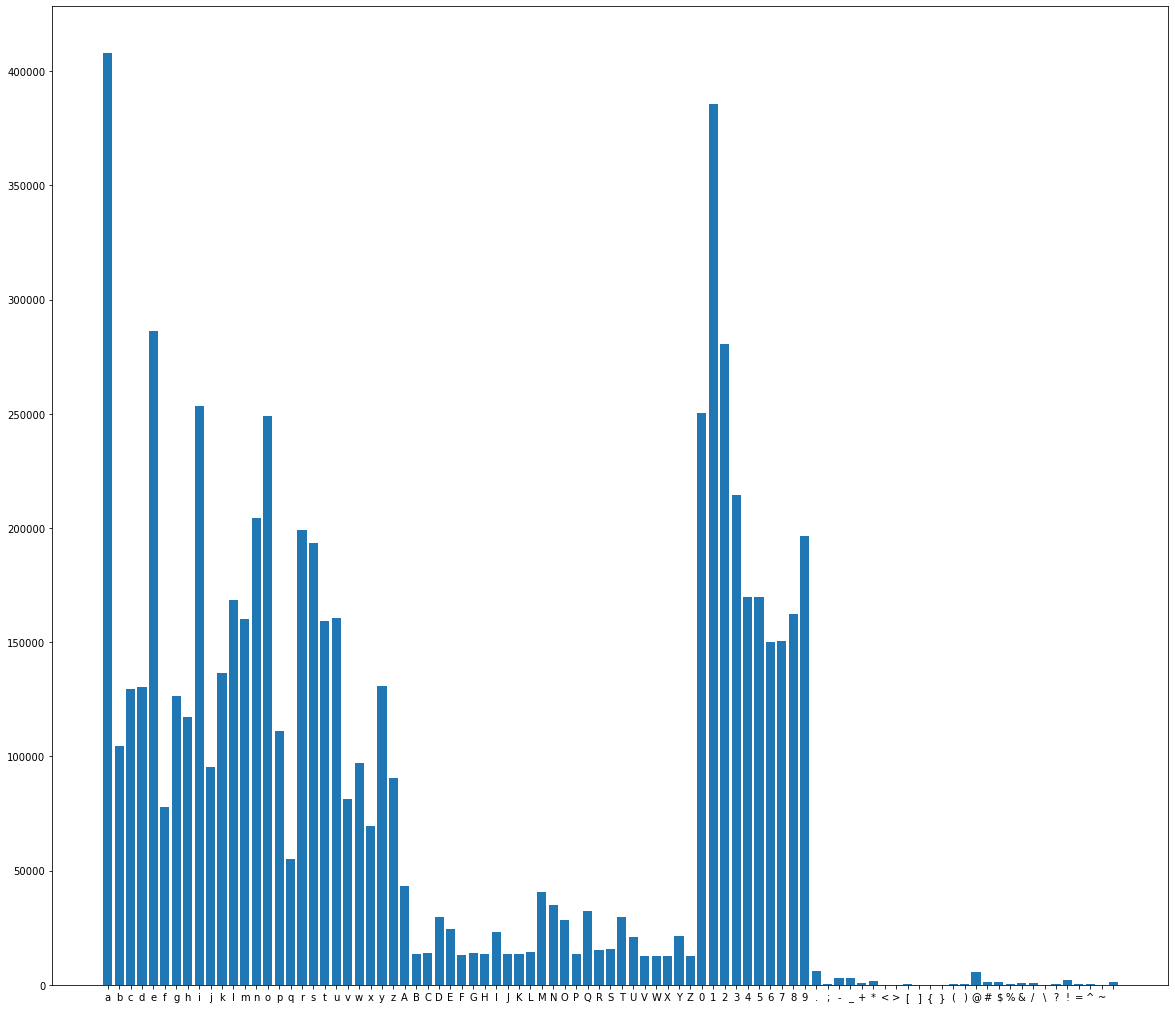

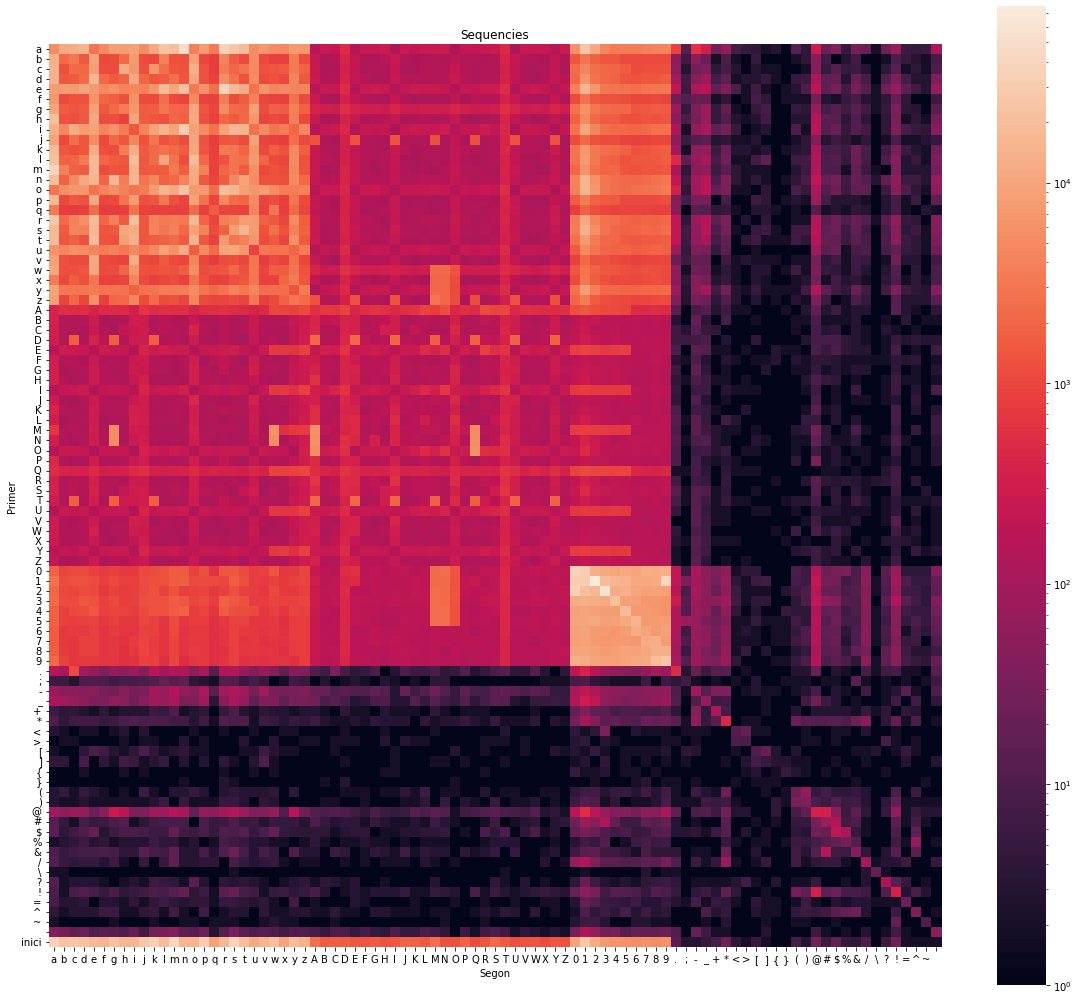

In [7]:
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

plt.subplots(figsize=(20, 18))
plt.bar(individual.keys(), individual.values())
plt.show()

plt.subplots(figsize=(20, 18))
sns.heatmap([[e for e in d.values()] for d in predictabilitat.values()], \
            xticklabels=CaractersValids, yticklabels=CaractersValids + ['inici'], square=True, norm=LogNorm())
plt.xlabel("Segon")
plt.ylabel("Primer")
plt.title("Sequencies")
plt.show()

In [8]:
def probabilitat_caracters(x):
    res = 1
    valid = 0
    for c in x:
        res *= individual.get(c, 1)
        valid += 1
    return res / (individual_total ** valid)

def probabilitat_sequencia(x):
    res = 1
    c_ = ''
    for c in x:
        if c not in CaractersValids:
            continue
        res *= predictabilitat[c_][c] / predictabilitat_total[c_]
        c_ = c
    return res

def aleatorietat(x):
    res = 1
    c_ = ''
    for c in x:
        if c not in CaractersValids:
            continue
        res *= individual[c] / predictabilitat[c_][c] * predictabilitat_total[c_] / individual_total
        c_ = c
    return res

def llargada(x):
    return len(x)

In [9]:
dades_caracters = np.vectorize(probabilitat_caracters)(contrasenyes)
dades_sequencia = np.vectorize(probabilitat_sequencia)(contrasenyes)
dades_aleatorietat = np.vectorize(aleatorietat)(contrasenyes)
dades_llargada = np.vectorize(llargada)(contrasenyes)

In [10]:
DP = np.stack((dades_caracters, dades_sequencia, dades_aleatorietat, dades_llargada, dades_proteccio), axis=-1)
dfDP = pd.DataFrame(data=DP, columns=['caracters', 'sequencia', 'aleatorietat', 'llargada', 'proteccio'])

D:\Archivos de programa\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


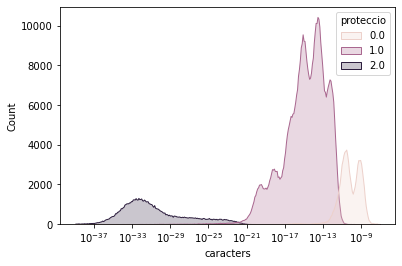

In [11]:
sns.histplot(data=dfDP, x="caracters", hue="proteccio", multiple="layer", log_scale=True, binrange=[-39, -7], element="poly")
plt.show()

D:\Archivos de programa\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


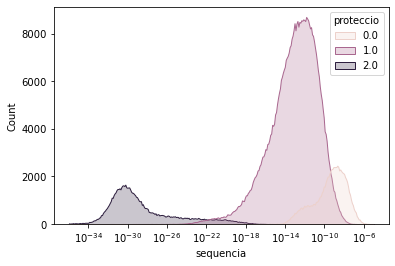

In [12]:
sns.histplot(data=dfDP, x="sequencia", hue="proteccio", multiple="layer", log_scale=True, binrange=[-36, -5], element="poly")
plt.show()

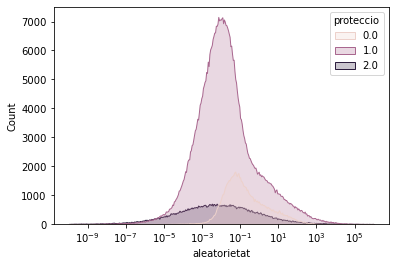

In [13]:
sns.histplot(data=dfDP, x="aleatorietat", hue="proteccio", multiple="layer", log_scale=True, binrange=[-10, 6], element="poly")
plt.show()

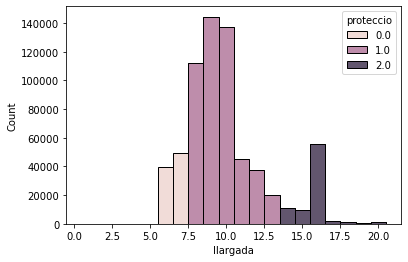

In [14]:
sns.histplot(data=dfDP, x="llargada", hue="proteccio", multiple="stack", discrete=True, binrange=[1, 20])
plt.show()

### Probar eficacia de les dades

In [15]:
def make_subset(X, y, p=1, index=None, returnUnusedIndex=False):
    if index is not None:
        l = len(index)
        idx = returnUnusedIndex
    else:
        l = len(y)
        index = np.array([i for i in range(l)])
        idx = False
    if p == 1:
        new_X = X[index]
        new_y = y[index]
        index = np.array([])
        unique, counts = np.unique(new_y, return_counts=True)
        values = {u: l / len(unique) / c for u, c in zip(unique, counts)}
        ret = (new_X, new_y, np.array([values[yi] for yi in new_y]))
    elif type(p) == list:
        subsets = []
        f = 1
        for pi in p:
            elem, index = make_subset(X, y, p=pi / f, index=index, returnUnusedIndex=True)
            subsets.append(elem)
            f -= pi
        subsets.append(make_subset(X, y, index=index))
        ret = (subsets)
    else:
        new_l = int(l * p)
        ind = np.random.choice(index, new_l, replace=False)
        index = np.setdiff1d(index, ind)
        new_X = X[ind]
        new_y = y[ind]
        unique, counts = np.unique(new_y, return_counts=True)
        values = {u: new_l / len(unique) / c for u, c in zip(unique, counts)}
        ret = (new_X, new_y, np.array([values[yi] for yi in new_y]))
    if idx:
        return ret, index
    else:
        return ret

def Wt(w, n):
    return w * n / len(w)

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

class LogPipe:
    err = np.float64(1e-200)
    def __init__ (self, columns):
        self.column_transform = columns
    
    def fit (self, X, **args):
        return self
    
    def transform(self, X, copy=True):
        if copy == True:
            X_tr = np.copy(X)
        else:
            X_tr = X
        X_tr[:, self.column_transform] = np.log(X_tr[:, self.column_transform].astype(np.float64) + LogPipe.err)
        return X_tr
    
    def fit_transform(self, X, y=None, copy=True, **args):
        return self.transform(X, copy)

def visualize_confusion_matrix(y_pred, y_real, w=None):
    #mostra la matriu de confusió
    cm = confusion_matrix(y_real, y_pred, sample_weight=w)
    plt.subplots(figsize=(10, 6))
    sns.heatmap(cm, annot = True, fmt = 'g')
    plt.xlabel("Predicted")
    plt.ylabel("Real")
    plt.title("Confusion Matrix")
    plt.show()

Accuracy: 100.0%
Macro accuracy: 100.0%


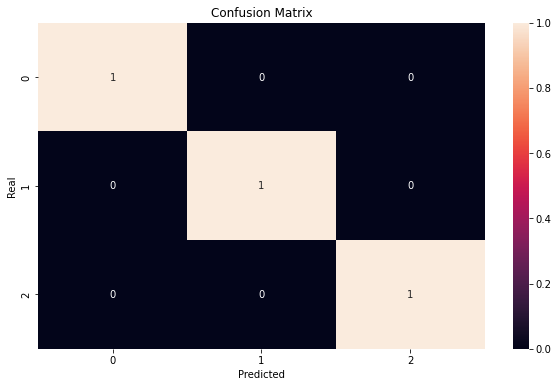

,caracters,sequencia,aleatorietat,llargada,1
0,1.395448,1.400668,0.146428,-47.237391,-14.341341
1,-0.007331,0.021482,-0.104077,3.874908,32.991872
2,-1.388117,-1.422150,-0.042351,43.362483,-18.650531


In [17]:
pipe1 = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1e6, C=100))])

atrib1 = ['caracters', 'sequencia', 'aleatorietat', 'llargada']
objP = 'proteccio'
atribDP = dfDP[atrib1].values
objDP = dfDP[objP].values

x_t, y_t, w_t = make_subset(atribDP, objDP, .2)
x_cv, y_cv, w_cv = make_subset(atribDP, objDP, 1)
pipe1.fit(x_t, y_t, model__sample_weight=w_t)
prediccio = pipe1.predict(x_cv)

print(f'Accuracy: {np.round(100 * sum(y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(w_cv * (y_cv==prediccio)) / len(prediccio), 3)}%')
visualize_confusion_matrix(prediccio, y_cv, Wt(w_cv, 3))

dfP1 = pd.DataFrame(pipe1['model'].coef_, columns=atrib1)
dfP1['1'] = pipe1['model'].intercept_
dfP1

Veiem que arriba al 100% donant importancia a la llargada, una posible explicació sería que només amb la llargada ja fos suficient per extreure el nivell de protecció tal com ho semblaba al histograma.

In [18]:
for i in range(3):
    print(f'Per nivell de protecció {i} la llargada es troba entre {min(dades_llargada[dades_proteccio == i])} i {max(dades_llargada[dades_proteccio == i])}.')

Per nivell de protecció 0 la llargada es troba entre 1 i 7.
Per nivell de protecció 1 la llargada es troba entre 8 i 13.
Per nivell de protecció 2 la llargada es troba entre 14 i 220.


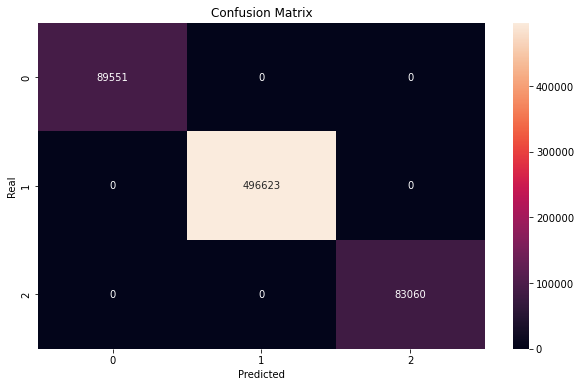

In [19]:
%matplotlib inline
prediccio = np.array([0 if len(x) < 8 else (2 if len(x) > 13 else 1) for x in contrasenyes])
visualize_confusion_matrix(prediccio, dades_proteccio)

Fent aquest comporbació veïem que en efecte és posible deduir el nivell de protecció donada la longitud de la contrasenya.
Tot i que ara tinguem un mètode que ens dona un 100% de precisió, com, segons diu el dataset, està format pels casos on coincideixen tres algoritmes diferents. LLavors buscarem a veure si hi ha algun altre manera de predir el nivell de seguretat.

### Probar eficacia de les dades (sense longitud)

Accuracy: 95.317%
Macro accuracy: 96.812%


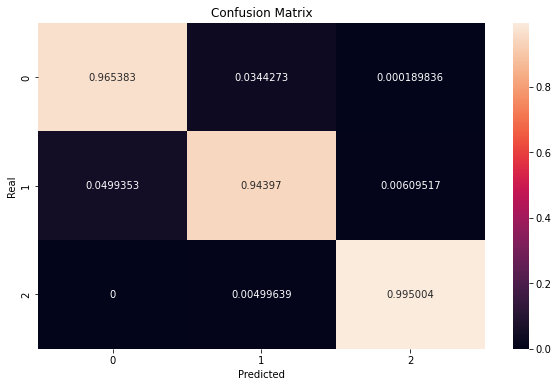

,caracters,sequencia,aleatorietat,1
0,6.463117,6.139132,1.970312,-3.730583
1,-0.674236,-0.551293,-0.524321,6.195067
2,-5.788882,-5.587839,-1.445991,-2.464484


In [20]:
pipe1b = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1e6, C=100))])

atrib1b = ['caracters', 'sequencia', 'aleatorietat']
objP = 'proteccio'
atribDP = dfDP[atrib1b].values
objDP = dfDP[objP].values

x_t, y_t, w_t = make_subset(atribDP, objDP, .2)
x_cv, y_cv, w_cv = make_subset(atribDP, objDP, 1)
pipe1b.fit(x_t, y_t, model__sample_weight=w_t)
prediccio = pipe1b.predict(x_cv)

print(f'Accuracy: {np.round(100 * sum(y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(w_cv * (y_cv==prediccio)) / len(prediccio), 3)}%')
visualize_confusion_matrix(prediccio, y_cv, Wt(w_cv, 3))

dfP1b = pd.DataFrame(pipe1b['model'].coef_, columns=atrib1b)
dfP1b['1'] = pipe1b['model'].intercept_
dfP1b

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
kFolds = 5

Accuracy: 95.294%
Macro accuracy: 96.8%


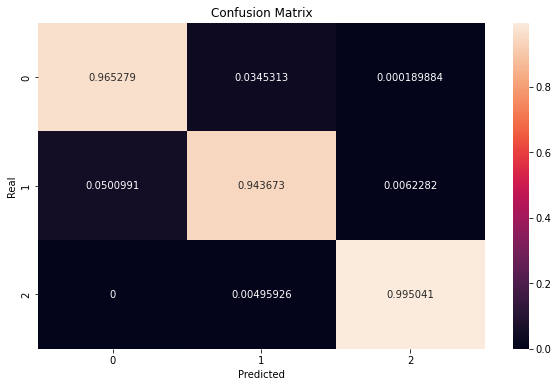

In [22]:
pipe = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', LogisticRegression())])

atribDP = dfDP[atrib1b].values
objDP = dfDP[objP].values

Y_cv, W_cv, prediccio = [], [], []

kf = KFold(n_splits=kFolds)
for train_index, test_index in kf.split(objDP):
    x_t, y_t, w_t = make_subset(atribDP[train_index], objDP[train_index])
    x_cv, y_cv, w_cv = make_subset(atribDP[test_index], objDP[test_index])
    pipe.fit(x_t, y_t, model__sample_weight=w_t) # model__sample_weight=w_t

    Y_cv.append(y_cv)
    W_cv.append(w_cv)
    prediccio.append(pipe.predict(x_cv))
    
Y_cv = np.concatenate(Y_cv)
W_cv = np.concatenate(W_cv)
prediccio = np.concatenate(prediccio)

print(f'Accuracy: {np.round(100 * sum(Y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(W_cv * (Y_cv==prediccio)) / len(prediccio), 3)}%')
visualize_confusion_matrix(prediccio, Y_cv, Wt(W_cv, 3))

MSE: 0.6690343030398476
R^2: 0.9152201404232233


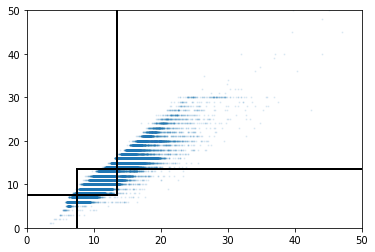

In [23]:
pipe = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', LinearRegression())])

atribDP = dfDP[atrib1b].values
objL = 'llargada'
objDP = dfDP[objL].values

Y_cv, prediccio = [], []

kf = KFold(n_splits=kFolds)
for train_index, test_index in kf.split(objDP):
    x_t, y_t = atribDP[train_index], objDP[train_index]
    x_cv, y_cv = atribDP[test_index], objDP[test_index]
    pipe.fit(x_t, y_t)

    Y_cv.append(y_cv)
    prediccio.append(pipe.predict(x_cv))
    
Y_cv = np.concatenate(Y_cv)
prediccio = np.concatenate(prediccio)

print(f'MSE: {sum((Y_cv - prediccio) ** 2) / len(prediccio)}')
print(f'R^2: {r2_score(Y_cv, prediccio)}')
fig = plt.figure()
plt.xlim([0,50])
plt.ylim([0,50])
ax = plt.gca()
plt.scatter(x=prediccio, y=Y_cv, s=1, alpha=.1)
plt.plot([0, 13.5], [7.5, 7.5], color='k', linestyle='-', linewidth=2, alpha=1)
plt.plot([7.5, 7.5], [0, 13.5], color='k', linestyle='-', linewidth=2, alpha=1)
plt.plot([7.5, 50], [13.5, 13.5], color='k', linestyle='-', linewidth=2, alpha=1)
plt.plot([13.5, 13.5], [7.5, 50], color='k', linestyle='-', linewidth=2, alpha=1)
plt.show()

[...]

## Predictabilitat (mitja)

Per treure la correlació que hi ha entre les dades de probabilitat i de llargada (més caracters més improbable) només calcularemm la mitja d'aquests valors.  
Per tant tindrem:
* Mitja de la probabilitat dels caracters que utilitza
* Mitja de la probabilitat d'una sequencia com aquesta
* Com de barrejats estàn els carcters

In [24]:
def mitja_caracters(x):
    res = 0
    valid = 0
    for c in x:
        res += np.log(individual.get(c, 1))
        valid += 1
    return np.exp(res / valid) / individual_total if valid > 0 else 1

def mitja_sequencia(x):
    res = 1
    c_ = ''
    valid = 0
    for c in x:
        if c not in CaractersValids:
            continue
        res *= predictabilitat[c_][c] / predictabilitat_total[c_]
        c_ = c
        valid += 1
    return res ** (1 / valid) if valid > 0 else 1

In [25]:
dades_mitja_caracters = np.vectorize(mitja_caracters)(contrasenyes)
dades_mitja_sequencia = np.vectorize(mitja_sequencia)(contrasenyes)

In [26]:
dfDP[['mitja caracters', 'mitja sequencia']] = np.stack((dades_mitja_caracters, dades_mitja_sequencia), axis=-1)

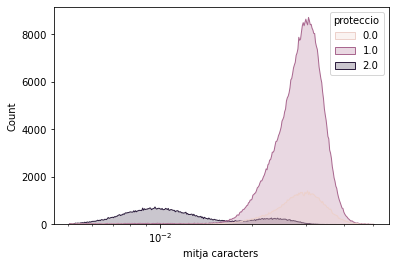

In [27]:
sns.histplot(data=dfDP, x="mitja caracters", hue="proteccio", multiple="layer", log_scale=True, binrange=[-2.3, -1.3], element="poly")
plt.show()

D:\Archivos de programa\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


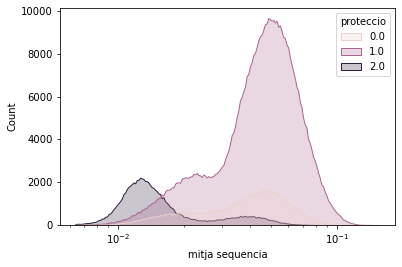

In [28]:
sns.histplot(data=dfDP, x="mitja sequencia", hue="proteccio", multiple="layer", log_scale=True, binrange=[-2.2, -0.8], element="poly")
plt.show()

### Probar eficacia de les dades

Accuracy: 78.071%
Macro accuracy: 83.791%


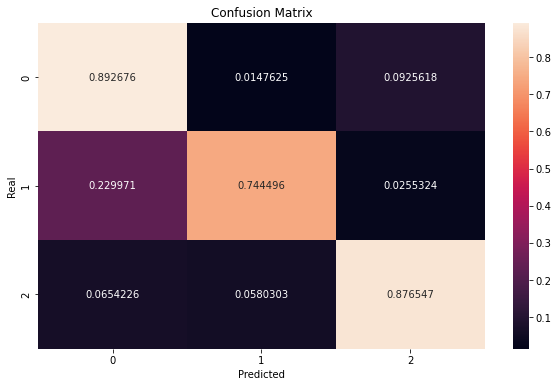

,mitja caracters,mitja sequencia,aleatorietat,1
0,-3.070806,5.749310,4.852362,-0.131378
1,0.765114,-0.121649,-0.773951,1.154896
2,2.305693,-5.627661,-4.078411,-1.023518


In [29]:
pipe2 = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1e6, C=100))])

atrib2 = ['mitja caracters', 'mitja sequencia', 'aleatorietat']
atribDP = dfDP[atrib2].values
objDP = dfDP[objP].values

x_t, y_t, w_t = make_subset(atribDP, objDP, .2)
x_cv, y_cv, w_cv = make_subset(atribDP, objDP, 1)
pipe2.fit(x_t, y_t, model__sample_weight=w_t)
prediccio = pipe2.predict(x_cv)

print(f'Accuracy: {np.round(100 * sum(y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(w_cv * (y_cv==prediccio)) / len(prediccio), 3)}%')
visualize_confusion_matrix(prediccio, y_cv, Wt(w_cv, 3))

dfP2 = pd.DataFrame(pipe2['model'].coef_, columns=atrib2)
dfP2['1'] = pipe2['model'].intercept_
dfP2

Accuracy: 78.079%
Macro accuracy: 83.772%


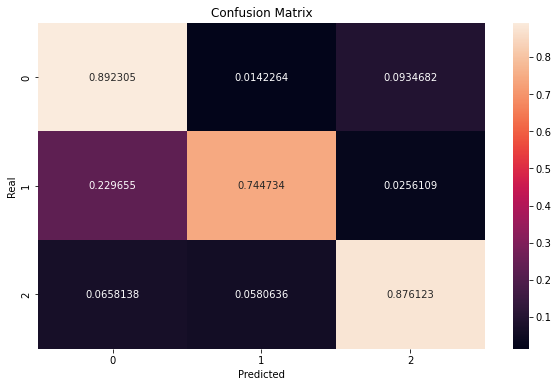

In [30]:
pipe = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', LogisticRegression())])

atribDP = dfDP[atrib2].values
objDP = dfDP[objP].values

Y_cv, W_cv, prediccio = [], [], []

kf = KFold(n_splits=kFolds)
for train_index, test_index in kf.split(objDP):
    x_t, y_t, w_t = make_subset(atribDP[train_index], objDP[train_index])
    x_cv, y_cv, w_cv = make_subset(atribDP[test_index], objDP[test_index])
    pipe.fit(x_t, y_t, model__sample_weight=w_t)

    Y_cv.append(y_cv)
    W_cv.append(w_cv)
    prediccio.append(pipe.predict(x_cv))
    
Y_cv = np.concatenate(Y_cv)
W_cv = np.concatenate(W_cv)
prediccio = np.concatenate(prediccio)

print(f'Accuracy: {np.round(100 * sum(Y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(W_cv * (Y_cv==prediccio)) / len(prediccio), 3)}%')
visualize_confusion_matrix(prediccio, Y_cv, Wt(W_cv, 3))

MSE: 4.641140377195555
R^2: 0.4118758520049699


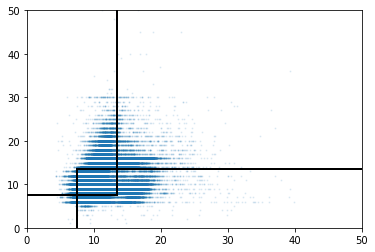

In [31]:
pipe = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', LinearRegression())])

atribDP = dfDP[atrib2].values
objDP = dfDP[objL].values

Y_cv, prediccio = [], []

kf = KFold(n_splits=kFolds)
for train_index, test_index in kf.split(objDP):
    x_t, y_t = atribDP[train_index], objDP[train_index]
    x_cv, y_cv = atribDP[test_index], objDP[test_index]
    pipe.fit(x_t, y_t)

    Y_cv.append(y_cv)
    prediccio.append(pipe.predict(x_cv))
    
Y_cv = np.concatenate(Y_cv)
prediccio = np.concatenate(prediccio)

print(f'MSE: {sum((Y_cv - prediccio) ** 2) / len(prediccio)}')
print(f'R^2: {r2_score(Y_cv, prediccio)}')
fig = plt.figure()
plt.xlim([0,50])
plt.ylim([0,50])
ax = plt.gca()
plt.scatter(x=prediccio, y=Y_cv, s=1, alpha=.1)
plt.plot([0, 13.5], [7.5, 7.5], color='k', linestyle='-', linewidth=2, alpha=1)
plt.plot([7.5, 7.5], [0, 13.5], color='k', linestyle='-', linewidth=2, alpha=1)
plt.plot([7.5, 50], [13.5, 13.5], color='k', linestyle='-', linewidth=2, alpha=1)
plt.plot([13.5, 13.5], [7.5, 50], color='k', linestyle='-', linewidth=2, alpha=1)
plt.show()

[...]

## Cadenes

Per mirar que tant variada és una contrasenya també es pot fer mirant quantes vegdes cambia o durant quant és manté utilitzant un tipus de caracters en concret (majuscules, minuscules, xifres i caracters especials).  
En aquest cas mirarem quant duren de mitja aquestes cadenes del mateix tipus de caracters de dues formes:
* Mitja de la longitud de les cadenes
* Mitja ponderada de la longitud de les cadenes

In [32]:
def mitja_cadena(x):
    canvis = 0
    valid = 0
    ultim = "Cap"
    for c in x:
        actual = TipusCaracters.get(c, "Cap")
        if actual == "Cap":
            continue
        elif not actual == ultim:
            ultim = actual
            canvis += 1
        valid += 1
    return valid / canvis if not canvis == 0 else 0

def ponderacio_cadena(x):
    valid = 0
    S, s = 0, 1
    ultim = "Cap"
    for c in x:
        actual = TipusCaracters.get(c, "Cap")
        if actual == "Cap":
            continue
        elif not actual == ultim:
            ultim = actual
            s = 1
        else:
            s += 2
        S += s
        valid += 1
    return S / valid if not valid == 0 else 0

In [33]:
dades_mitja_cadena = np.vectorize(mitja_cadena)(contrasenyes)
dades_ponderacio_cadena = np.vectorize(ponderacio_cadena)(contrasenyes)

In [34]:
dfDP[['mitja cadena', 'ponderacio cadena']] = np.stack((dades_mitja_cadena, dades_ponderacio_cadena), axis=-1)

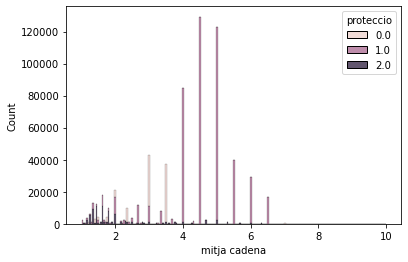

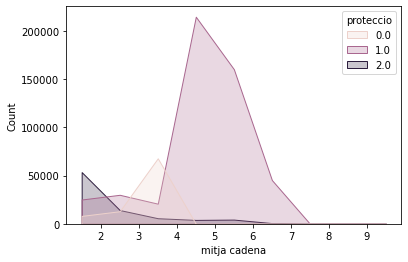

In [35]:
sns.histplot(data=dfDP, x="mitja cadena", hue="proteccio", multiple="stack", binrange=[1, 10])
plt.show()
sns.histplot(data=dfDP, x="mitja cadena", hue="proteccio", multiple="layer", binwidth=1, binrange=[1, 10], element="poly")
plt.show()

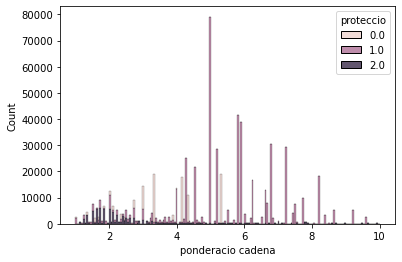

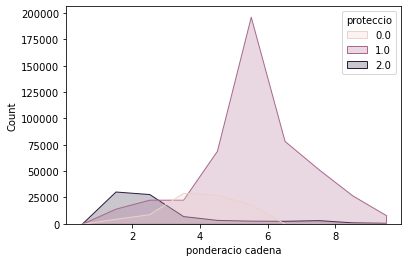

In [36]:
sns.histplot(data=dfDP, x="ponderacio cadena", hue="proteccio", multiple="stack", binrange=[1, 10])
plt.show()
sns.histplot(data=dfDP, x="ponderacio cadena", hue="proteccio", multiple="layer", binwidth=1, binrange=[0, 10], element="poly")
plt.show()

### Probar eficacia de les dades

Accuracy: 84.397%
Macro accuracy: 83.836%


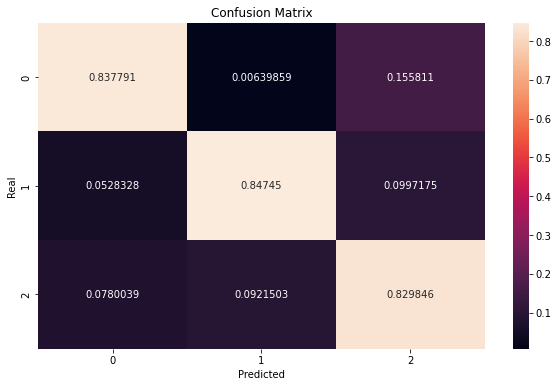

,mitja cadena,ponderacio cadena,1
0,0.544998,-0.662520,0.551286
1,2.808800,-1.234511,0.873346
2,-3.353798,1.897031,-1.424632


In [37]:
pipe3 = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1e6, C=100))])

atrib3 = ['mitja cadena', 'ponderacio cadena']
atribDP = dfDP[atrib3].values
objDP = dfDP[objP].values

x_t, y_t, w_t = make_subset(atribDP, objDP, .2)
x_cv, y_cv, w_cv = make_subset(atribDP, objDP, 1)
pipe3.fit(x_t, y_t, model__sample_weight=w_t)
prediccio = pipe3.predict(x_cv)

print(f'Accuracy: {np.round(100 * sum(y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(w_cv * (y_cv==prediccio)) / len(prediccio), 3)}%')
visualize_confusion_matrix(prediccio, y_cv, Wt(w_cv, 3))

dfP3 = pd.DataFrame(pipe3['model'].coef_, columns=atrib3)
dfP3['1'] = pipe3['model'].intercept_
dfP3

Accuracy: 84.404%
Macro accuracy: 83.853%


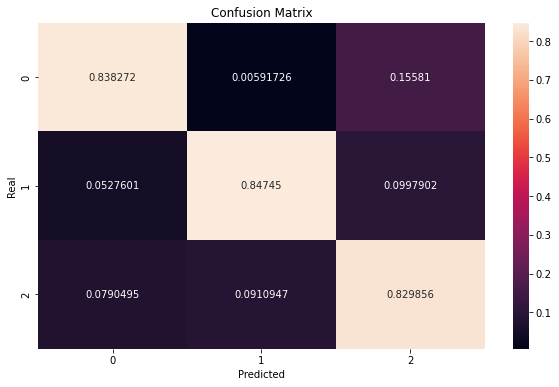

In [38]:
pipe = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression())])

atribDP = dfDP[atrib3].values
objDP = dfDP[objP].values

Y_cv, W_cv, prediccio = [], [], []

kf = KFold(n_splits=kFolds)
for train_index, test_index in kf.split(objDP):
    x_t, y_t, w_t = make_subset(atribDP[train_index], objDP[train_index])
    x_cv, y_cv, w_cv = make_subset(atribDP[test_index], objDP[test_index])
    pipe.fit(x_t, y_t, model__sample_weight=w_t)

    Y_cv.append(y_cv)
    W_cv.append(w_cv)
    prediccio.append(pipe.predict(x_cv))
    
Y_cv = np.concatenate(Y_cv)
W_cv = np.concatenate(W_cv)
prediccio = np.concatenate(prediccio)

print(f'Accuracy: {np.round(100 * sum(Y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(W_cv * (Y_cv==prediccio)) / len(prediccio), 3)}%')
visualize_confusion_matrix(prediccio, Y_cv, Wt(W_cv, 3))

MSE: 7.715049273844307
R^2: 0.02235088531037932


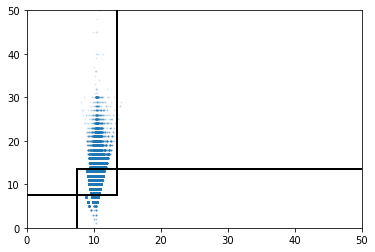

In [39]:
pipe = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])

atribDP = dfDP[atrib3].values
objDP = dfDP[objL].values

Y_cv, prediccio = [], []

kf = KFold(n_splits=kFolds)
for train_index, test_index in kf.split(objDP):
    x_t, y_t = atribDP[train_index], objDP[train_index]
    x_cv, y_cv = atribDP[test_index], objDP[test_index]
    pipe.fit(x_t, y_t)

    Y_cv.append(y_cv)
    prediccio.append(pipe.predict(x_cv))
    
Y_cv = np.concatenate(Y_cv)
prediccio = np.concatenate(prediccio)

print(f'MSE: {sum((Y_cv - prediccio) ** 2) / len(prediccio)}')
print(f'R^2: {r2_score(Y_cv, prediccio)}')
fig = plt.figure()
plt.xlim([0,50])
plt.ylim([0,50])
ax = plt.gca()
plt.scatter(x=prediccio, y=Y_cv, s=1, alpha=.1)
plt.plot([0, 13.5], [7.5, 7.5], color='k', linestyle='-', linewidth=2, alpha=1)
plt.plot([7.5, 7.5], [0, 13.5], color='k', linestyle='-', linewidth=2, alpha=1)
plt.plot([7.5, 50], [13.5, 13.5], color='k', linestyle='-', linewidth=2, alpha=1)
plt.plot([13.5, 13.5], [7.5, 50], color='k', linestyle='-', linewidth=2, alpha=1)
plt.show()

Sembla que, a pesar de donar una millor classificació, no es suficient per extreure la informació de la longitud, per tant és una bona nova mesura.

## Tipus de caracters

Finalment mirarem quins tipus de caracters utilitza (majuscules, minuscules, xifres i caracters especials) ja que aquesta és una de les coses que en diversos llocs s'asseguren de que facis per que tinguis una contrasenya segura.  
Per tant els últims seràn:
* Conté alguna minuscula
* Conté alguna majuscula
* Conté alguna xifra
* Conté algun caracter especial

In [40]:
def teMinuscules(contrasenya):
    return any(c in Minuscules for c in contrasenya)

def teMajuscules(contrasenya):
    return any(c in Majuscules for c in contrasenya)

def teXifres(contrasenya):
    return any(c in Xifres for c in contrasenya)

def teEspecials(contrasenya):
    return any(c in Especials for c in contrasenya)

In [41]:
dades_minuscules = np.vectorize(teMinuscules)(contrasenyes)
dades_majuscules = np.vectorize(teMajuscules)(contrasenyes)
dades_xifres = np.vectorize(teXifres)(contrasenyes)
dades_especials = np.vectorize(teEspecials)(contrasenyes)

In [42]:
dfDP[['minuscules', 'majuscules', 'xifres', 'especials']] = np.stack((dades_minuscules, dades_majuscules, dades_xifres, dades_especials), axis=-1)
dfDP['caracter_flags'] = dfDP['minuscules'] + 2 * dfDP['majuscules'] + 4 * dfDP['xifres'] + 8 * dfDP['especials']

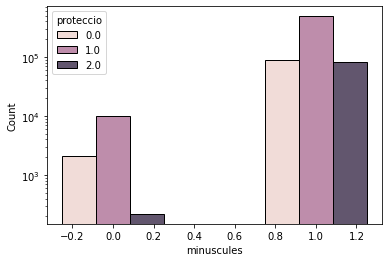

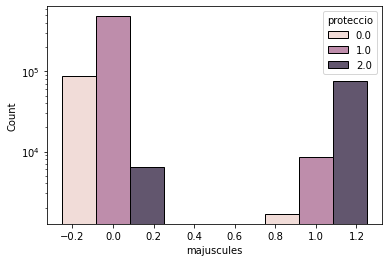

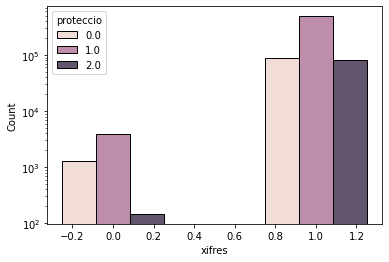

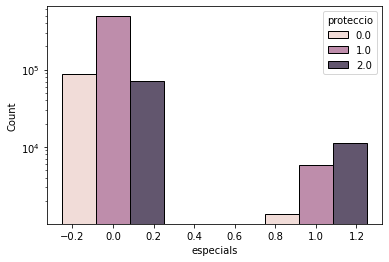

In [43]:
sns.histplot(data=dfDP, x="minuscules", hue="proteccio", multiple="dodge", shrink=.5, discrete=True)
ax=plt.gca()
ax.set_yscale('log')
plt.show()
sns.histplot(data=dfDP, x="majuscules", hue="proteccio", multiple="dodge", shrink=.5, discrete=True)
ax=plt.gca()
ax.set_yscale('log')
plt.show()
sns.histplot(data=dfDP, x="xifres", hue="proteccio", multiple="dodge", shrink=.5, discrete=True)
ax=plt.gca()
ax.set_yscale('log')
plt.show()
sns.histplot(data=dfDP, x="especials", hue="proteccio", multiple="dodge", shrink=.5, discrete=True)
ax=plt.gca()
ax.set_yscale('log')
plt.show()

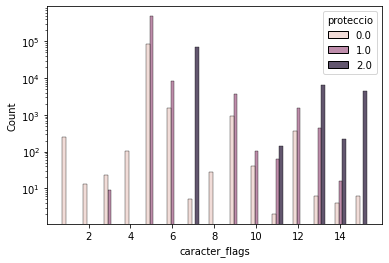

In [44]:
sns.histplot(data=dfDP, x="caracter_flags", hue="proteccio", multiple="dodge", shrink=.5, discrete=True)
ax=plt.gca()
ax.set_yscale('log')
plt.show()

### Probar eficacia de les dades

Accuracy: 84.973%
Macro accuracy: 66.937%


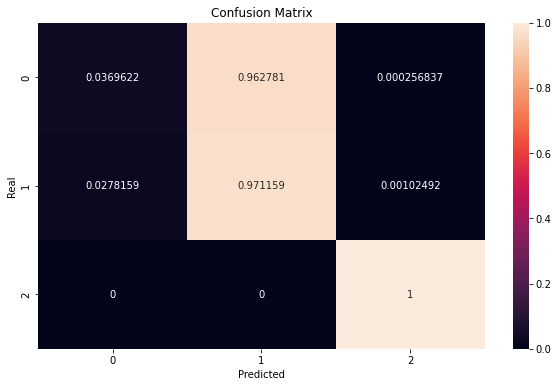

,minuscules,majuscules,xifres,especials,1
0,-1.485968,-3.516849,-0.980976,-1.431701,3.457733
1,-0.970059,-2.253434,-0.625703,-0.818296,3.951374
2,2.456028,5.770283,1.606679,2.249997,-7.409108


In [45]:
pipe4 = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1e6, C=100))])

atrib4 = ['minuscules', 'majuscules', 'xifres', 'especials']
atribDP = dfDP[atrib4].values
objDP = dfDP[objP].values

x_t, y_t, w_t = make_subset(atribDP, objDP, .2)
x_cv, y_cv, w_cv = make_subset(atribDP, objDP, 1)
pipe4.fit(x_t, y_t, model__sample_weight=w_t)
prediccio = pipe4.predict(x_cv)

print(f'Accuracy: {np.round(100 * sum(y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(w_cv * (y_cv==prediccio)) / len(prediccio), 3)}%')
visualize_confusion_matrix(prediccio, y_cv, Wt(w_cv, 3))

dfP4 = pd.DataFrame(pipe4['model'].coef_, columns=atrib4)
dfP4['1'] = pipe4['model'].intercept_
dfP4

Accuracy: 0.8497326794514325
Macro accuracy: 0.6693739377833533


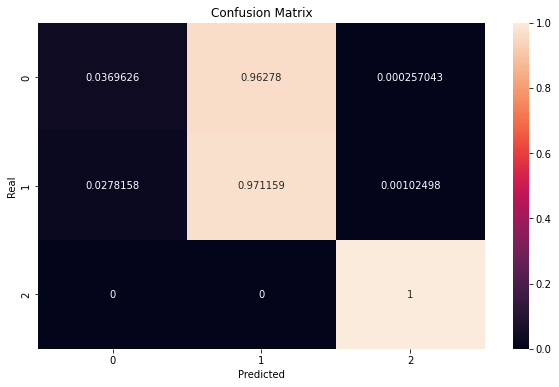

In [46]:
pipe = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression())])

atribDP = dfDP[atrib4].values
objDP = dfDP[objP].values

Y_cv, W_cv, prediccio = [], [], []

kf = KFold(n_splits=kFolds)
for train_index, test_index in kf.split(objDP):
    x_t, y_t, w_t = make_subset(atribDP[train_index], objDP[train_index])
    x_cv, y_cv, w_cv = make_subset(atribDP[test_index], objDP[test_index])
    pipe.fit(x_t, y_t, model__sample_weight=w_t) # model__sample_weight=w_t

    Y_cv.append(y_cv)
    W_cv.append(w_cv)
    prediccio.append(pipe.predict(x_cv))
    
Y_cv = np.concatenate(Y_cv)
W_cv = np.concatenate(W_cv)
prediccio = np.concatenate(prediccio)

print(f'Accuracy: {sum(Y_cv==prediccio) / len(prediccio)}')
print(f'Macro accuracy: {sum(W_cv * (Y_cv==prediccio)) / len(prediccio)}')
visualize_confusion_matrix(prediccio, Y_cv, Wt(W_cv, 3))

MSE: 3.052421636929491
R^2: 0.6131978934828799


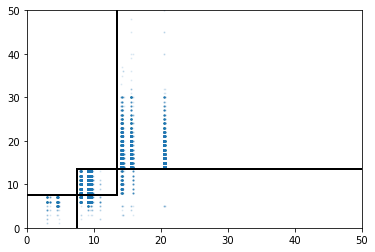

In [47]:
pipe = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])

atribDP = dfDP[atrib4].values
objDP = dfDP[objL].values

Y_cv, prediccio = [], []

kf = KFold(n_splits=kFolds)
for train_index, test_index in kf.split(objDP):
    x_t, y_t = atribDP[train_index], objDP[train_index]
    x_cv, y_cv = atribDP[test_index], objDP[test_index]
    pipe.fit(x_t, y_t)

    Y_cv.append(y_cv)
    prediccio.append(pipe.predict(x_cv))
    
Y_cv = np.concatenate(Y_cv)
prediccio = np.concatenate(prediccio)

print(f'MSE: {sum((Y_cv - prediccio) ** 2) / len(prediccio)}')
print(f'R^2: {r2_score(Y_cv, prediccio)}')
fig = plt.figure()
plt.xlim([0,50])
plt.ylim([0,50])
ax = plt.gca()
plt.scatter(x=prediccio, y=Y_cv, s=1, alpha=.1)
plt.plot([0, 13.5], [7.5, 7.5], color='k', linestyle='-', linewidth=2, alpha=1)
plt.plot([7.5, 7.5], [0, 13.5], color='k', linestyle='-', linewidth=2, alpha=1)
plt.plot([7.5, 50], [13.5, 13.5], color='k', linestyle='-', linewidth=2, alpha=1)
plt.plot([13.5, 13.5], [7.5, 50], color='k', linestyle='-', linewidth=2, alpha=1)
plt.show()

Serveixen molt bé per distingir quan alguna mostra pertany al nivell de protecció 2. Per la predicció que fan de la llargada, és poden veure talls en la continuitat de les franjes, el que indica que algun dels algoritmes ha utilitzat aquesta informació per qualificar la seguretat de la contrasenya.

# 3. Escollir un model

In [48]:
from sklearn import ensemble
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

import time

kFolds = 3
set_reduction = .1

atrib23 = atrib2 + atrib3
atrib34 = atrib3 + atrib4
atrib24 = atrib2 + atrib4
atribAll = atrib2 + atrib3 + atrib4

Accuracy: 89.35%
Macro accuracy: 93.572%
Time elapsed: 14.058137893676758s


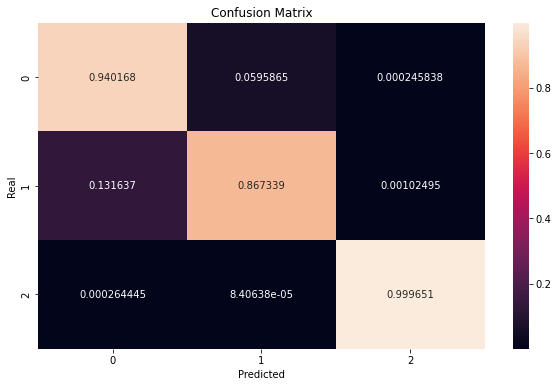

In [49]:
pipe = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1e6))])

atribDP = dfDP[atribAll].values
objDP = dfDP[objP].values

Y_cv, W_cv, prediccio = [], [], []

kf = KFold(n_splits=kFolds)
init_time = time.time()
for train_index, test_index in kf.split(objDP):
    x_t, y_t, w_t = make_subset(atribDP[train_index], objDP[train_index], set_reduction)
    x_cv, y_cv, w_cv = make_subset(atribDP[test_index], objDP[test_index])
    pipe.fit(x_t, y_t, model__sample_weight=w_t)

    Y_cv.append(y_cv)
    W_cv.append(w_cv)
    prediccio.append(pipe.predict(x_cv))
elapsed = time.time() - init_time
    
Y_cv = np.concatenate(Y_cv)
W_cv = np.concatenate(W_cv)
prediccio = np.concatenate(prediccio)

print(f'Accuracy: {np.round(100 * sum(Y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(W_cv * (Y_cv==prediccio)) / len(prediccio), 3)}%')
print(f'Time elapsed: {elapsed}s')
visualize_confusion_matrix(prediccio, Y_cv, Wt(W_cv, 3))

Accuracy: 82.364%
Macro accuracy: 85.897%
Time elapsed: 4.714260101318359s


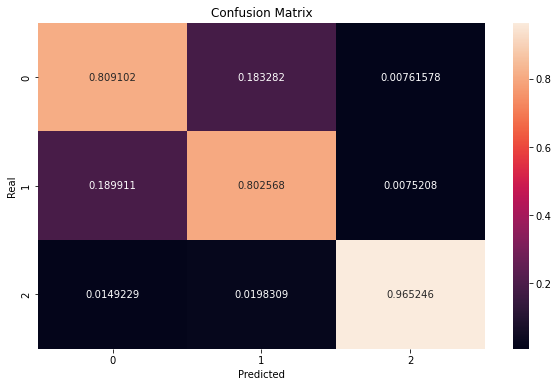

In [50]:
pipe = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()),\
                 ('PCA', PCA(n_components=5)), ('model', LogisticRegression(max_iter=1e6))])

atribDP = dfDP[atribAll].values
objDP = dfDP[objP].values

Y_cv, W_cv, prediccio = [], [], []

kf = KFold(n_splits=kFolds)
init_time = time.time()
for train_index, test_index in kf.split(objDP):
    x_t, y_t, w_t = make_subset(atribDP[train_index], objDP[train_index], set_reduction)
    x_cv, y_cv, w_cv = make_subset(atribDP[test_index], objDP[test_index])
    pipe.fit(x_t, y_t, model__sample_weight=w_t)

    Y_cv.append(y_cv)
    W_cv.append(w_cv)
    prediccio.append(pipe.predict(x_cv))
elapsed = time.time() - init_time
    
Y_cv = np.concatenate(Y_cv)
W_cv = np.concatenate(W_cv)
prediccio = np.concatenate(prediccio)

print(f'Accuracy: {np.round(100 * sum(Y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(W_cv * (Y_cv==prediccio)) / len(prediccio), 3)}%')
print(f'Time elapsed: {elapsed}s')
visualize_confusion_matrix(prediccio, Y_cv, Wt(W_cv, 3))

Accuracy: 88.776%
Macro accuracy: 94.873%
Time elapsed: 7.294477701187134s


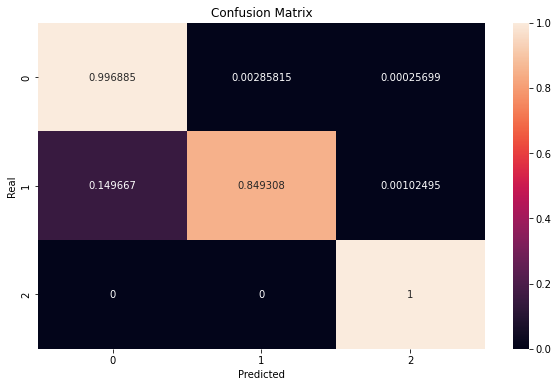

In [51]:
pipe = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1e6))])

atribDP = dfDP[atrib34].values
objDP = dfDP[objP].values

Y_cv, W_cv, prediccio = [], [], []

kf = KFold(n_splits=kFolds)
init_time = time.time()
for train_index, test_index in kf.split(objDP):
    x_t, y_t, w_t = make_subset(atribDP[train_index], objDP[train_index], set_reduction)
    x_cv, y_cv, w_cv = make_subset(atribDP[test_index], objDP[test_index])
    pipe.fit(x_t, y_t, model__sample_weight=w_t)

    Y_cv.append(y_cv)
    W_cv.append(w_cv)
    prediccio.append(pipe.predict(x_cv))
elapsed = time.time() - init_time
    
Y_cv = np.concatenate(Y_cv)
W_cv = np.concatenate(W_cv)
prediccio = np.concatenate(prediccio)

print(f'Accuracy: {np.round(100 * sum(Y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(W_cv * (Y_cv==prediccio)) / len(prediccio), 3)}%')
print(f'Time elapsed: {elapsed}s')
visualize_confusion_matrix(prediccio, Y_cv, Wt(W_cv, 3))

Accuracy: 87.116%
Macro accuracy: 92.604%
Time elapsed: 449.23945236206055s


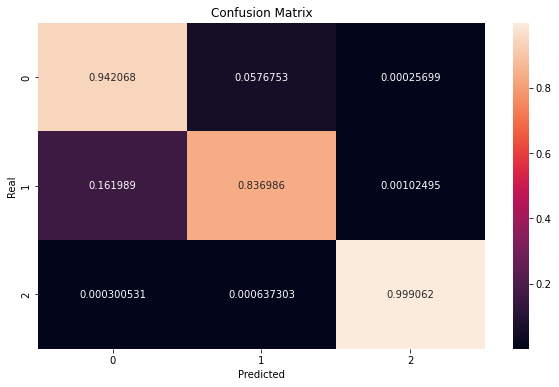

In [52]:
pipe = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', LinearSVC(max_iter=1e6))])

atribDP = dfDP[atribAll].values
objDP = dfDP[objP].values

Y_cv, W_cv, prediccio = [], [], []

kf = KFold(n_splits=kFolds)
init_time = time.time()
for train_index, test_index in kf.split(objDP):
    x_t, y_t, w_t = make_subset(atribDP[train_index], objDP[train_index], set_reduction)
    x_cv, y_cv, w_cv = make_subset(atribDP[test_index], objDP[test_index])
    pipe.fit(x_t, y_t, model__sample_weight=w_t)

    Y_cv.append(y_cv)
    W_cv.append(w_cv)
    prediccio.append(pipe.predict(x_cv))
elapsed = time.time() - init_time
    
Y_cv = np.concatenate(Y_cv)
W_cv = np.concatenate(W_cv)
prediccio = np.concatenate(prediccio)

print(f'Accuracy: {np.round(100 * sum(Y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(W_cv * (Y_cv==prediccio)) / len(prediccio), 3)}%')
print(f'Time elapsed: {elapsed}s')
visualize_confusion_matrix(prediccio, Y_cv, Wt(W_cv, 3))

Accuracy: 92.163%
Macro accuracy: 96.416%
Time elapsed: 730.9859571456909s


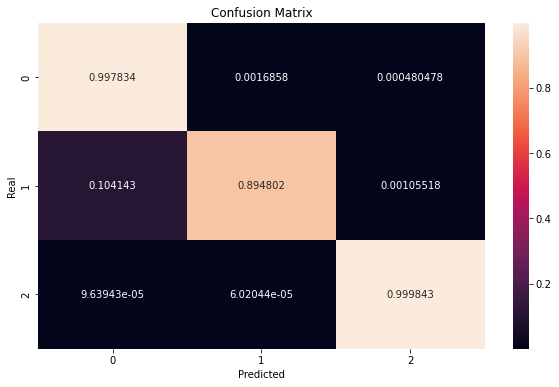

In [53]:
pipe = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', SVC())])

atribDP = dfDP[atribAll].values
objDP = dfDP[objP].values

Y_cv, W_cv, prediccio = [], [], []

kf = KFold(n_splits=kFolds)
init_time = time.time()
for train_index, test_index in kf.split(objDP):
    x_t, y_t, w_t = make_subset(atribDP[train_index], objDP[train_index], set_reduction)
    x_cv, y_cv, w_cv = make_subset(atribDP[test_index], objDP[test_index])
    pipe.fit(x_t, y_t, model__sample_weight=w_t)

    Y_cv.append(y_cv)
    W_cv.append(w_cv)
    prediccio.append(pipe.predict(x_cv))
elapsed = time.time() - init_time
    
Y_cv = np.concatenate(Y_cv)
W_cv = np.concatenate(W_cv)
prediccio = np.concatenate(prediccio)

print(f'Accuracy: {np.round(100 * sum(Y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(W_cv * (Y_cv==prediccio)) / len(prediccio), 3)}%')
print(f'Time elapsed: {elapsed}s')
visualize_confusion_matrix(prediccio, Y_cv, Wt(W_cv, 3))

Accuracy: 85.676%
Macro accuracy: 88.901%
Time elapsed: 1.9799411296844482s


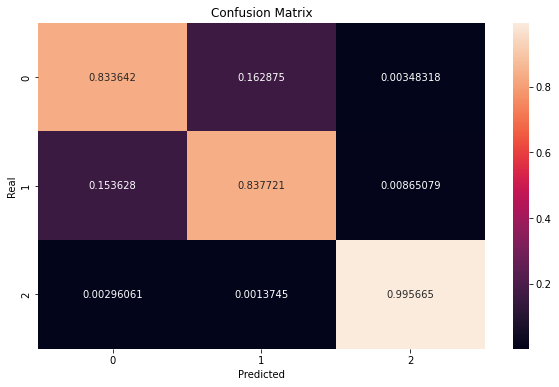

In [54]:
pipe = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', GaussianNB())])

atribDP = dfDP[atribAll].values
objDP = dfDP[objP].values

Y_cv, W_cv, prediccio = [], [], []

kf = KFold(n_splits=kFolds)
init_time = time.time()
for train_index, test_index in kf.split(objDP):
    x_t, y_t, w_t = make_subset(atribDP[train_index], objDP[train_index], set_reduction)
    x_cv, y_cv, w_cv = make_subset(atribDP[test_index], objDP[test_index])
    pipe.fit(x_t, y_t, model__sample_weight=w_t)

    Y_cv.append(y_cv)
    W_cv.append(w_cv)
    prediccio.append(pipe.predict(x_cv))
elapsed = time.time() - init_time
    
Y_cv = np.concatenate(Y_cv)
W_cv = np.concatenate(W_cv)
prediccio = np.concatenate(prediccio)

print(f'Accuracy: {np.round(100 * sum(Y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(W_cv * (Y_cv==prediccio)) / len(prediccio), 3)}%')
print(f'Time elapsed: {elapsed}s')
visualize_confusion_matrix(prediccio, Y_cv, Wt(W_cv, 3))

Accuracy: 85.103%
Macro accuracy: 89.212%
Time elapsed: 18.8676335811615s


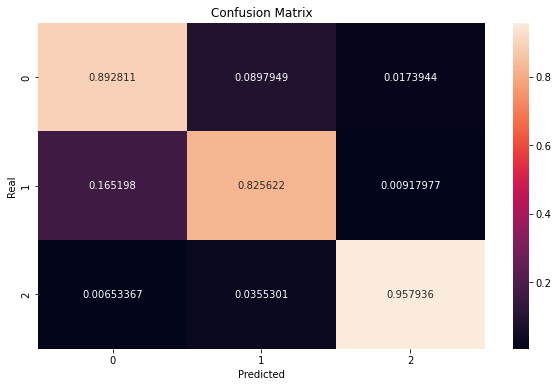

In [55]:
pipe = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', BaggingClassifier(LogisticRegression(), max_samples=0.5, max_features=0.5))])

atribDP = dfDP[atribAll].values
objDP = dfDP[objP].values

Y_cv, W_cv, prediccio = [], [], []

kf = KFold(n_splits=kFolds)
init_time = time.time()
for train_index, test_index in kf.split(objDP):
    x_t, y_t, w_t = make_subset(atribDP[train_index], objDP[train_index], set_reduction)
    x_cv, y_cv, w_cv = make_subset(atribDP[test_index], objDP[test_index])
    pipe.fit(x_t, y_t, model__sample_weight=w_t)

    Y_cv.append(y_cv)
    W_cv.append(w_cv)
    prediccio.append(pipe.predict(x_cv))
elapsed = time.time() - init_time
    
Y_cv = np.concatenate(Y_cv)
W_cv = np.concatenate(W_cv)
prediccio = np.concatenate(prediccio)

print(f'Accuracy: {np.round(100 * sum(Y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(W_cv * (Y_cv==prediccio)) / len(prediccio), 3)}%')
print(f'Time elapsed: {elapsed}s')
visualize_confusion_matrix(prediccio, Y_cv, Wt(W_cv, 3))

Accuracy: 99.151%
Macro accuracy: 98.986%
Time elapsed: 3.739938735961914s


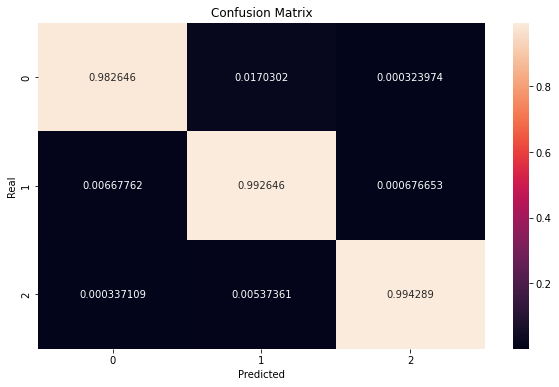

In [56]:
pipe = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', RandomForestClassifier(n_estimators=10, max_depth=20))])

atribDP = dfDP[atribAll].values
objDP = dfDP[objP].values

Y_cv, W_cv, prediccio = [], [], []

kf = KFold(n_splits=kFolds)
init_time = time.time()
for train_index, test_index in kf.split(objDP):
    x_t, y_t, w_t = make_subset(atribDP[train_index], objDP[train_index], set_reduction)
    x_cv, y_cv, w_cv = make_subset(atribDP[test_index], objDP[test_index])
    pipe.fit(x_t, y_t, model__sample_weight=w_t)

    Y_cv.append(y_cv)
    W_cv.append(w_cv)
    prediccio.append(pipe.predict(x_cv))
elapsed = time.time() - init_time
    
Y_cv = np.concatenate(Y_cv)
W_cv = np.concatenate(W_cv)
prediccio = np.concatenate(prediccio)

print(f'Accuracy: {np.round(100 * sum(Y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(W_cv * (Y_cv==prediccio)) / len(prediccio), 3)}%')
print(f'Time elapsed: {elapsed}s')
visualize_confusion_matrix(prediccio, Y_cv, Wt(W_cv, 3))

Accuracy: 99.335%
Macro accuracy: 99.452%
Time elapsed: 2.2861526012420654s


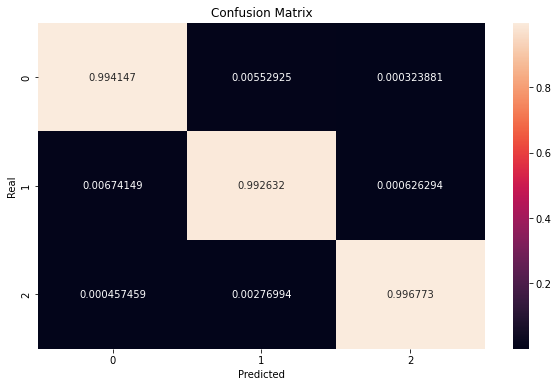

In [57]:
pipe = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', RandomForestClassifier(n_estimators=10, max_depth=20))])

atribDP = dfDP[atrib34].values
objDP = dfDP[objP].values

Y_cv, W_cv, prediccio = [], [], []

kf = KFold(n_splits=kFolds)
init_time = time.time()
for train_index, test_index in kf.split(objDP):
    x_t, y_t, w_t = make_subset(atribDP[train_index], objDP[train_index], set_reduction)
    x_cv, y_cv, w_cv = make_subset(atribDP[test_index], objDP[test_index])
    pipe.fit(x_t, y_t, model__sample_weight=w_t)

    Y_cv.append(y_cv)
    W_cv.append(w_cv)
    prediccio.append(pipe.predict(x_cv))
elapsed = time.time() - init_time
    
Y_cv = np.concatenate(Y_cv)
W_cv = np.concatenate(W_cv)
prediccio = np.concatenate(prediccio)

print(f'Accuracy: {np.round(100 * sum(Y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(W_cv * (Y_cv==prediccio)) / len(prediccio), 3)}%')
print(f'Time elapsed: {elapsed}s')
visualize_confusion_matrix(prediccio, Y_cv, Wt(W_cv, 3))

In [58]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import sys

def train(model, train_data, optimizer, criterion):
    X, y, w = train_data
    losses = []
    model.train()
    kf = KFold(n_splits=5)
    for _, index in kf.split(y):
        x_b, y_b = torch.Tensor(X[index].astype(np.float64)), torch.LongTensor(y[index].astype(np.int64))
        optimizer.zero_grad()
        output = model(x_b)
        loss = criterion(output, y_b)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

def test(model, test_data, criterion, showConfusionMatrix=False):
    model.eval()
    test_loss = 0
    correct = 0
    totals = 0
    X, y, w = test_data
    Y_cv, W_cv, prediccio = [], [], []
    
    with torch.no_grad():
        kf = KFold(n_splits=5)
        for _, index in kf.split(y):
            x_b, y_b, w_b = torch.Tensor(X[index].astype(np.float64)), torch.LongTensor(y[index].astype(np.int64)), torch.Tensor(w[index].astype(np.float64))
            output = model(x_b)
            test_loss += criterion(output, y_b).item() * x_b.shape[0]
            pred = output.argmax(dim=1)
            Y_cv.append(np.asarray(y_b))
            W_cv.append(np.asarray(w_b))
            prediccio.append(np.asarray(pred))

    Y_cv = np.concatenate(Y_cv)
    W_cv = np.concatenate(W_cv)
    prediccio = np.concatenate(prediccio)
    
    test_loss /= len(y)
    accuracy = 100 * sum(W_cv * (Y_cv==prediccio)) / len(prediccio)
    
    if showConfusionMatrix:
        visualize_confusion_matrix(prediccio, Y_cv, Wt(W_cv, 3))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, sum(Y_cv==prediccio), len(prediccio), accuracy))
    return test_loss, accuracy

def NNTrain(model, epochs, loss, optimizer, train_data, test_data, name=''):
    init_time = time.time()
    losses_train = []
    losses_test = []
    accuracies_test = []
    print('--'*50)
    print('STARTING TRAINING OF {}'.format(name))
    print('--'*50)
    
    device = torch.device('cpu')
    model.to(device)
    print("CHECKING INITIAL TEST LOSS (with random weights..)")
    # calculo aquest test tan sols per visualitzar més maca la gràfica de losses. No caldria utilitzar-lo
    loss_test_epoch, accuracy_epoch = test(model, test_data, loss)
    losses_test.append(loss_test_epoch)
    accuracies_test.append(accuracy_epoch)
    
    for epoch in range(1, epochs + 1):
        print ("EPOCH {}".format(epoch))
        sys.stdout.flush()
        loss_train_epoch = train(model, train_data, optimizer, loss)
        if epoch == epochs:
            loss_test_epoch, accuracy_epoch = test(model, test_data, loss, showConfusionMatrix=True)
        else:
            loss_test_epoch, accuracy_epoch = test(model, test_data, loss)

        losses_train.extend(loss_train_epoch)
        losses_test.append(loss_test_epoch)
        accuracies_test.append(accuracy_epoch)

    plt.plot(range(len(losses_train)), 
             losses_train, label="Training Loss")

    plt.plot(range(0, len(losses_train)+1, int(len(losses_train)/(len(losses_test)-1))), 
             losses_test, label="Test Loss")
    ax = plt.gca()
    ax.set_yscale('log')
    plt.legend()
    plt.show()

    plt.plot(range(0, len(accuracies_test), int(len(accuracies_test)/(len(accuracies_test)-1))), 
             accuracies_test, label="Accuracy")
    plt.show()
    
    elapsed = time.time()-init_time

    print ("ELAPSED TIME: {:.1f}s".format(elapsed))

    return losses_train, losses_test, accuracies_test, elapsed

In [59]:
class NNet(nn.Module):
    def __init__(self, p):
        super(NNet, self).__init__()
        self.fc1 = nn.Linear(p, 32)
        self.fc2 = nn.Linear(32, 10)
        self.fc3 = nn.Linear(10, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

----------------------------------------------------------------------------------------------------
STARTING TRAINING OF NNET
----------------------------------------------------------------------------------------------------
CHECKING INITIAL TEST LOSS (with random weights..)

Test set: Average loss: 5.5700, Accuracy: 27457/223078 (33.33%)

EPOCH 1

Test set: Average loss: 7.5648, Accuracy: 116268/223078 (51.22%)

EPOCH 2

Test set: Average loss: 6.9419, Accuracy: 155299/223078 (33.64%)

EPOCH 3

Test set: Average loss: 2.3218, Accuracy: 161729/223078 (33.55%)

EPOCH 4

Test set: Average loss: 8.5729, Accuracy: 161248/223078 (38.48%)

EPOCH 5

Test set: Average loss: 11.2070, Accuracy: 175419/223078 (56.52%)

EPOCH 6

Test set: Average loss: 11.6418, Accuracy: 176218/223078 (56.88%)

EPOCH 7

Test set: Average loss: 10.7743, Accuracy: 173769/223078 (58.85%)

EPOCH 8

Test set: Average loss: 9.1266, Accuracy: 174633/223078 (66.61%)

EPOCH 9

Test set: Average loss: 7.0087, Accuracy: 1

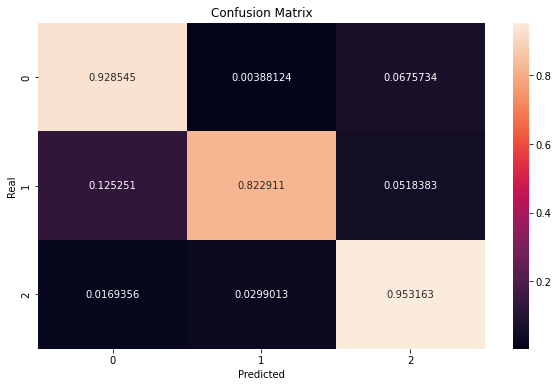


Test set: Average loss: 47.2613, Accuracy: 190334/223078 (90.15%)



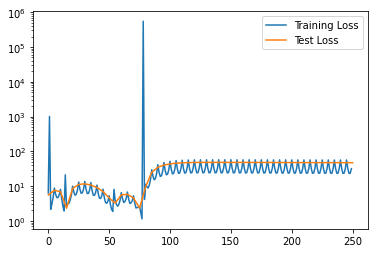

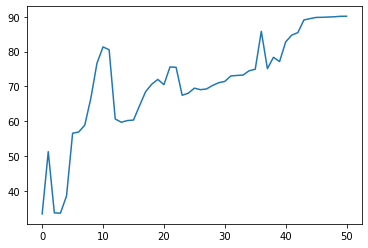

ELAPSED TIME: 86.4s


In [60]:
atribDP = dfDP[atribAll].values
objDP = dfDP[objP].values

train_data, test_data = make_subset(atribDP, objDP, [1-1/kFolds])

learning_rate = 0.01
modelNNet = NNet(len(atribAll))
loss = nn.CrossEntropyLoss(weight=torch.Tensor([1/sum(train_data[1]==0), 1/sum(train_data[1]==1), 1/sum(train_data[1]==2)]))
optimizer = torch.optim.Adam(modelNNet.parameters(), lr=learning_rate)
loss_train, loss_test, acc_test, elapsedNL = NNTrain(modelNNet, 50, loss, optimizer, 
                                                      train_data, test_data, name='NNET')

In [61]:
class CustomClassifier:
    def __init__(self, classifier1, classifier2=None, **classifier_args):
        # Separar arguments que només siguin per un
        clf1_args = {key if not key.startswith('clf1_') else key[5:] : arg\
                     for key, arg in classifier_args.items() if not key.startswith('clf2_')}
        clf2_args = {key if not key.startswith('clf2_') else key[5:] : arg\
                     for key, arg in classifier_args.items() if not key.startswith('clf1_')}
        # Utilitzar el mateix classificador si només s'ha indicat un
        if classifier2 is None:
            classifier2 = classifier1
        self.clf1 = classifier1(**clf1_args)
        self.clf2 = classifier2(**clf2_args)
    
    def fit(self, X, y, sample_weight=None):
        ind = (y<2)
        # Diferenciar entre (0, 1) i (2)
        X1, y1, sample_weight1 = X, np.copy(y), sample_weight
        y1[ind] = 0
        self.clf1.fit(X1, y1, sample_weight=sample_weight1)
        # Diferenciar entre (0) i (1)
        X2, y2, sample_weight2 = np.copy(X)[ind], np.copy(y)[ind], np.copy(sample_weight)[ind]
        self.clf2.fit(X2, y2, sample_weight=sample_weight2)
    
    def predict(self, X, **predict_params):
        pred = self.clf1.predict(X, **predict_params)
        ind = (pred<2)
        if sum(ind) > 0:
            pred[ind] = self.clf2.predict(X[ind], **predict_params)
        return pred


Accuracy: 99.337%
Macro accuracy: 99.554%
Time elapsed: 4.214337587356567s


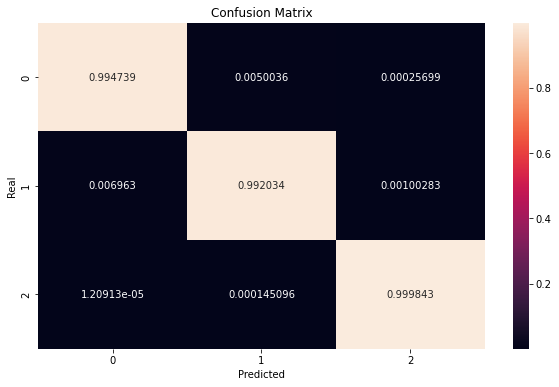

In [62]:
pipe = Pipeline([('scaler', StandardScaler()), ('model', CustomClassifier(LogisticRegression, RandomForestClassifier, clf1_C=10, clf2_n_estimators=10, clf2_max_depth=20))])

atribDP = dfDP[atrib34].values
objDP = dfDP[objP].values

Y_cv, W_cv, prediccio = [], [], []

kf = KFold(n_splits=kFolds)
init_time = time.time()
for train_index, test_index in kf.split(objDP):
    x_t, y_t, w_t = make_subset(atribDP[train_index], objDP[train_index], set_reduction)
    x_cv, y_cv, w_cv = make_subset(atribDP[test_index], objDP[test_index])
    pipe.fit(x_t, y_t, model__sample_weight=w_t)

    Y_cv.append(y_cv)
    W_cv.append(w_cv)
    prediccio.append(pipe.predict(x_cv))
elapsed = time.time() - init_time
    
Y_cv = np.concatenate(Y_cv)
W_cv = np.concatenate(W_cv)
prediccio = np.concatenate(prediccio)

print(f'Accuracy: {np.round(100 * sum(Y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(W_cv * (Y_cv==prediccio)) / len(prediccio), 3)}%')
print(f'Time elapsed: {elapsed}s')
visualize_confusion_matrix(prediccio, Y_cv, Wt(W_cv, 3))

In [63]:
from sklearn.ensemble import RandomForestRegressor

MSE: 0.38855213668657407
R^2: 0.9507627704037688


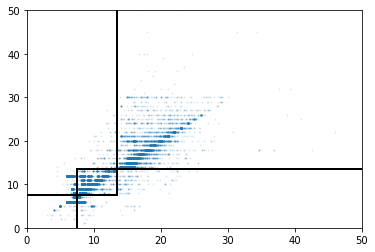

In [64]:
pipe = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', RandomForestRegressor(n_estimators=10, max_depth=20))])

atribDP = dfDP[atrib34].values
objDP = dfDP[objL].values

Y_cv, prediccio = [], []

kf = KFold(n_splits=kFolds)
for train_index, test_index in kf.split(objDP):
    x_t, y_t = atribDP[train_index], objDP[train_index]
    x_cv, y_cv = atribDP[test_index], objDP[test_index]
    pipe.fit(x_t, y_t)

    Y_cv.append(y_cv)
    prediccio.append(pipe.predict(x_cv))
    
Y_cv = np.concatenate(Y_cv)
prediccio = np.concatenate(prediccio)

print(f'MSE: {sum((Y_cv - prediccio) ** 2) / len(prediccio)}')
print(f'R^2: {r2_score(Y_cv, prediccio)}')
fig = plt.figure()
plt.xlim([0,50])
plt.ylim([0,50])
ax = plt.gca()
plt.scatter(x=prediccio, y=Y_cv, s=1, alpha=.1)
plt.plot([0, 13.5], [7.5, 7.5], color='k', linestyle='-', linewidth=2, alpha=1)
plt.plot([7.5, 7.5], [0, 13.5], color='k', linestyle='-', linewidth=2, alpha=1)
plt.plot([7.5, 50], [13.5, 13.5], color='k', linestyle='-', linewidth=2, alpha=1)
plt.plot([13.5, 13.5], [7.5, 50], color='k', linestyle='-', linewidth=2, alpha=1)
plt.show()

# 4. Millora dels models

De tots els models vistos farem la busqueda d'hyperparametres en el del random forest i en el classificador propi.  
Tot i que el model SVC amb kernel RBF dona també molt bons resultats triga massa amb una fracció del dataset per tal de poder fer proves per millorar el seu rendiment.

In [65]:
from sklearn.metrics import classification_report

def qualitat(atribDP, objDP, pipe, kFolds=5):
    kf = KFold(n_splits=kFolds)
    f1 = 0
    for train_index, test_index in kf.split(objDP):
        x_t, y_t, w_t = make_subset(atribDP[train_index], objDP[train_index])
        x_cv, y_cv, w_cv = make_subset(atribDP[test_index], objDP[test_index])
        pipe.fit(x_t, y_t, model__sample_weight=w_t)

        f1 += classification_report(y_cv, pipe.predict(x_cv), output_dict=True)['macro avg']['f1-score']
    return f1 / kFolds

In [66]:
# RandomForestClassifier
rfc_estimators = [5, 10, 20, 50]
rfc_criterions = ["'gini'", "'entropy'"]
rfc_max_depths = [10, 50, None]
rfc_max_features = ["'auto'", "'sqrt'", "'log2'"]

# LogisticRegression
lr_penalties = ["'l1'", "'l2'"]
lr_Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [67]:
pipe_str = "Pipeline([('scaler', StandardScaler()), ('model', RandomForestClassifier(n_estimators={}, criterion={}, max_depth={}, max_features={}))])"

atribDP = dfDP[atrib34].values
objDP = dfDP[objP].values
f1_max = 0

for rfc_estimator in rfc_estimators:
    for rfc_criterion in rfc_criterions:
        for rfc_max_depth in rfc_max_depths:
            for rfc_max_feature in rfc_max_features:
                f1 = qualitat(atribDP, objDP, eval(pipe_str.format(rfc_estimator, rfc_criterion, rfc_max_depth, rfc_max_feature)))
                if f1 > f1_max:
                    f1_max = f1
                    print("F1-score maxim: {}, per: {} estimadors, criteri {}, una profunditat de {} i {} caract.".format(f1_max, rfc_estimator, rfc_criterion, rfc_max_depth, rfc_max_feature))

F1-score maxim: 0.956386861950844, per: 5 estimadors, criteri 'gini', una profunditat de 10 i 'auto' caract.
F1-score maxim: 0.960029017913962, per: 5 estimadors, criteri 'gini', una profunditat de 10 i 'sqrt' caract.
F1-score maxim: 0.9915229743893498, per: 5 estimadors, criteri 'gini', una profunditat de 50 i 'auto' caract.
F1-score maxim: 0.9915808153006294, per: 5 estimadors, criteri 'gini', una profunditat de 50 i 'sqrt' caract.
F1-score maxim: 0.9915958418018572, per: 5 estimadors, criteri 'gini', una profunditat de None i 'auto' caract.
F1-score maxim: 0.9916320875514817, per: 5 estimadors, criteri 'gini', una profunditat de None i 'log2' caract.
F1-score maxim: 0.9916394442528176, per: 20 estimadors, criteri 'gini', una profunditat de 50 i 'sqrt' caract.
F1-score maxim: 0.9916421032930188, per: 20 estimadors, criteri 'gini', una profunditat de 50 i 'log2' caract.
F1-score maxim: 0.9916648938109122, per: 20 estimadors, criteri 'gini', una profunditat de None i 'log2' caract.


In [69]:
pipe_str = "Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', CustomClassifier(LogisticRegression, RandomForestClassifier, clf1_max_iter=1e6, clf1_solver='liblinear', clf1_penalty={}, clf1_C={}, clf2_n_estimators=20, clf2_criterion='gini', clf2_max_depth=None, clf2_max_features='log2'))])"

atribDP = dfDP[atrib34].values
objDP = dfDP[objP].values
f1_max = 0

for lr_penalty in lr_penalties:
    for lr_C in lr_Cs:
        f1 = qualitat(atribDP, objDP, eval(pipe_str.format(lr_penalty, lr_C)))
        if f1 > f1_max:
            f1_max = f1
            print("F1-score maxim: {}, per: {} penalty i C = {}.".format(f1_max, lr_penalty, lr_C))

F1-score maxim: 0.9911109420288821, per: 'l1' penalty i C = 0.001.
F1-score maxim: 0.9911301692424136, per: 'l1' penalty i C = 0.01.
F1-score maxim: 0.99113292646085, per: 'l1' penalty i C = 10.


Accuracy: 99.429%
Macro accuracy: 99.62%
Time elapsed: 17.959919929504395s


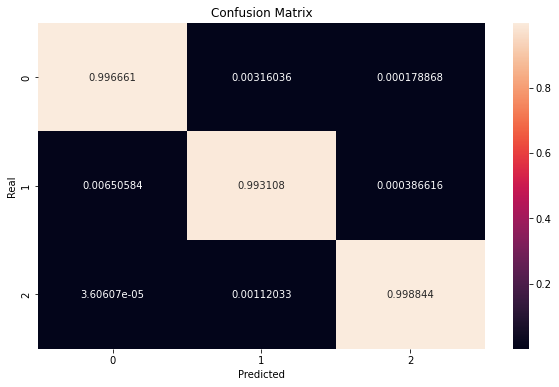

In [70]:
pipe = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', RandomForestClassifier(n_estimators=20, criterion='gini', max_depth=None, max_features='log2'))])

atribDP = dfDP[atrib34].values
objDP = dfDP[objP].values

Y_cv, W_cv, prediccio = [], [], []

kf = KFold(n_splits=kFolds)
init_time = time.time()
for train_index, test_index in kf.split(objDP):
    x_t, y_t, w_t = make_subset(atribDP[train_index], objDP[train_index])
    x_cv, y_cv, w_cv = make_subset(atribDP[test_index], objDP[test_index])
    pipe.fit(x_t, y_t, model__sample_weight=w_t)

    Y_cv.append(y_cv)
    W_cv.append(w_cv)
    prediccio.append(pipe.predict(x_cv))
elapsed = time.time() - init_time
    
Y_cv = np.concatenate(Y_cv)
W_cv = np.concatenate(W_cv)
prediccio = np.concatenate(prediccio)

print(f'Accuracy: {np.round(100 * sum(Y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(W_cv * (Y_cv==prediccio)) / len(prediccio), 3)}%')
print(f'Time elapsed: {elapsed}s')
visualize_confusion_matrix(prediccio, Y_cv, Wt(W_cv, 3))

Accuracy: 99.396%
Macro accuracy: 99.637%
Time elapsed: 19.185104846954346s


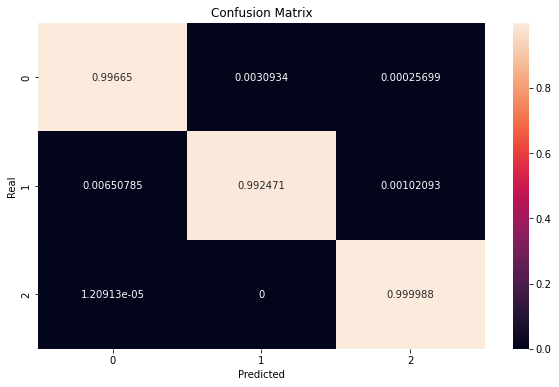

In [71]:
pipe = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', CustomClassifier(LogisticRegression, RandomForestClassifier, clf1_max_iter=1e6, clf1_solver='liblinear', clf1_penalty='l1', clf1_C=10, clf2_n_estimators=20, clf2_criterion='gini', clf2_max_depth=None, clf2_max_features='log2'))])

atribDP = dfDP[atrib34].values
objDP = dfDP[objP].values

Y_cv, W_cv, prediccio = [], [], []

kf = KFold(n_splits=kFolds)
init_time = time.time()
for train_index, test_index in kf.split(objDP):
    x_t, y_t, w_t = make_subset(atribDP[train_index], objDP[train_index])
    x_cv, y_cv, w_cv = make_subset(atribDP[test_index], objDP[test_index])
    pipe.fit(x_t, y_t, model__sample_weight=w_t)

    Y_cv.append(y_cv)
    W_cv.append(w_cv)
    prediccio.append(pipe.predict(x_cv))
elapsed = time.time() - init_time
    
Y_cv = np.concatenate(Y_cv)
W_cv = np.concatenate(W_cv)
prediccio = np.concatenate(prediccio)

print(f'Accuracy: {np.round(100 * sum(Y_cv==prediccio) / len(prediccio), 3)}%')
print(f'Macro accuracy: {np.round(100 * sum(W_cv * (Y_cv==prediccio)) / len(prediccio), 3)}%')
print(f'Time elapsed: {elapsed}s')
visualize_confusion_matrix(prediccio, Y_cv, Wt(W_cv, 3))

# 5. Resultats

In [72]:
pipe2 = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', RandomForestClassifier(n_estimators=20, criterion='gini', max_depth=50, max_features='sqrt'))])
pipe3 = Pipeline([('log', LogPipe([0, 1, 2])), ('scaler', StandardScaler()), ('model', CustomClassifier(LogisticRegression, RandomForestClassifier, clf1_max_iter=1e6, clf1_solver='liblinear', clf1_penalty='l1', clf1_C=10, clf2_n_estimators=20, clf2_criterion='gini', clf2_max_depth=None, clf2_max_features='log2'))])

atribDP = dfDP[atrib34].values
objDP = dfDP[objP].values

dades_t, objectiu_t, w_t = make_subset(atribDP, objDP)
pipe2.fit(dades_t, objectiu_t, model__sample_weight=w_t)
pipe3.fit(dades_t, objectiu_t, model__sample_weight=w_t)
pass

In [73]:
import ipywidgets as widgets
password = widgets.Text()
warning = widgets.Label()
strength1 = widgets.Label(disabled=True)
strength2 = widgets.Label()

def format2(x):
    return np.array([[mitja_cadena(x), ponderacio_cadena(x), teMinuscules(x), teMajuscules(x), teXifres(x), teEspecials(x)]])

def on_value_change(change):
    warning.value = ''
    if len(change['new']) < 6:
        warning.value = 'Massa curt'
    if not isValid(change['new']):
        password.value = change['old']
        warning.value = 'Caracter invalid'
    m1 = 0 if len(change['new']) < 8 else (2 if len(change['new']) > 13 else 1)
    m2 = int(pipe2.predict(format2(change['new']))[0])
    m3 = int(pipe3.predict(format2(change['new']))[0])
    strength1.value = 'seguretat metode 1: ' + str(m1)
    strength1.value += ', seguretat metode 2: ' + str(m2)
    strength1.value += ', seguretat metode 3: ' + str(m3)
    
    strength2.value = 'seguretat conjunta, minim: ' + str(min((m1, m3)))
    strength2.value += ', seguretat conjunta, mitja: ' + str(np.round(sum((m1, m3)) / 2, 1))

password.observe(on_value_change, names='value')
display(warning, password, strength1, strength2)

Label(value='')

Text(value='')

Label(value='')

Label(value='')